This code is based on the Matlab script written by C.A. Stock, NOAA GFDL used to generate Figure 11 in Stock et al., 2011

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.colors as plt_col
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

Could not save font_manager cache [Errno 28] No space left on device
/nbhome/role.medgrp/.conda/envs/medpy311/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
def calc_lims(t0,tn):
    
    # INITIALIZE STORAGE ARRAYS
    nlim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    plim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    felim_weighted_month = np.zeros((12,nmod_lat,nmod_lon))
    pp_month = np.zeros((12,nmod_lat,nmod_lon))
    
    for m in range(12):

        # Constituent productivity terms
        intppdiat = fid_mod.variables['intppdiat'][m,:].squeeze()
        intppmisc = fid_mod.variables['intppmisc'][m,:].squeeze()
        intpppico = fid_mod.variables['intpppico'][m,:].squeeze()

        # Limitation terms (picophytoplankton)
        limnpico  = fid_mod.variables['limnpico'][m,:].squeeze()
        limppico  = fid_mod.variables['limppico'][m,:].squeeze()
        limfepico = fid_mod.variables['limfepico'][m,:].squeeze()

        # Diatoms
        limndiat  = fid_mod.variables['limndiat'][m,:].squeeze()
        limpdiat  = fid_mod.variables['limpdiat'][m,:].squeeze()
        limfediat = fid_mod.variables['limfediat'][m,:].squeeze()

        # Miscellaneous
        limnmisc  = fid_mod.variables['limnmisc'][m,:].squeeze()
        limpmisc  = fid_mod.variables['limpmisc'][m,:].squeeze()
        limfemisc = fid_mod.variables['limfemisc'][m,:].squeeze()

        nlim_weighted_month[m,:]  = (intppdiat*limndiat + intppmisc*limnmisc + intpppico*limnpico)/\
                                    (intppdiat + intppmisc + intpppico)

        plim_weighted_month[m,:]  = (intppdiat*limpdiat + intppmisc*limpmisc + intpppico*limppico)/\
                                    (intppdiat + intppmisc + intpppico);

        felim_weighted_month[m,:] = (intppdiat*limfediat + intppmisc*limfemisc + intpppico*limfepico)/\
                                    (intppdiat + intppmisc + intpppico);

        pp_month[m,:] = (intppdiat + intpppico + intppmisc)*86400*num_days[m]*6.625*12 

    # Monthly weighted mean - seasonal enabled
    sum_pp_month = np.sum(pp_month[t0:tn,:],axis=0)
    
    nlim_weighted  = np.sum(nlim_weighted_month[t0:tn,:]*pp_month[t0:tn,:],axis=0)/sum_pp_month
    plim_weighted  = np.sum(plim_weighted_month[t0:tn,:]*pp_month[t0:tn,:],axis=0)/sum_pp_month
    felim_weighted = np.sum(felim_weighted_month[t0:tn,:]*pp_month[t0:tn,:],axis=0)/sum_pp_month
    
    aa = ~np.isfinite(felim_weighted)

    felim = felim_weighted - np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    felim[aa] = np.nan
    nlim  = nlim_weighted  - np.min(np.stack((felim_weighted,plim_weighted)),axis=0)
    nlim[aa] = np.nan
    plim  = plim_weighted  - np.min(np.stack((nlim_weighted,felim_weighted)),axis=0)
    plim[aa] = np.nan

    liebig_macro = np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    liebig = np.min(np.stack((liebig_macro,felim_weighted)),axis=0)

    # OLD METHOD - OVERRIDEN BY BELOW
    # initalize the storage array to keep indicies
    lim_ind = np.empty((nmod_lat,nmod_lon))
    # Somewhat N limitation
    lim_ind[nlim <= 0] = 1;
    # Somewhat P limited
    lim_ind[(plim <= 0) * (plim > -0.25)] = 1.5
    # P limited
    lim_ind[plim <= -0.25] = 2
    # Somewhat Fe limited
    lim_ind[(felim <= 0) * (felim > -0.25)] = 4.5
    # Fe limited
    lim_ind[felim <= -0.25] = 5
    
    lim_ind[lsm==0]=np.nan

    # ALTERNATIVE METHOD - DOES NOT YET OVERIDE ABOVE METHOD
    all_lims = np.vstack((nlim[np.newaxis,:],plim[np.newaxis,:],felim[np.newaxis,:]))
    # determine the min val across stacked dimension
    min_vals = np.min(all_lims,axis=0)
    # return index of minimum value - corresponds with identiy of the limitation: 
    #    0 = N, 1 = P, 2 = Fe
    min_idx = np.argmin(all_lims,axis=0).astype(float)
    # Add 1 to give more space
    min_idx+=1

    # Re-label iron limitation to 5
    min_idx[min_idx == 3] = 5

    # If the value is weak, it falls between 0 and -0.25, regardless of which nutrient
    weak_idx = (min_vals<=0)*(min_vals>-0.25)
    # subtract 0.5 for values that qualify as weakly limiting 
    #  0.5 = weak N, 1 = N, 1.5 = weak P, 2 = P, 4.5 = weak Fe, 5 = Fe
    min_idx[weak_idx] = min_idx[weak_idx] - 0.5
    # nan for land mask values
    min_idx[lsm ==0] = np.nan

    return lim_ind,min_idx


In [3]:
def plot_lim_map(ax,data):
    
    data[chuk_mask_nep]=np.nan

    #C = ax.pcolormesh(nep_clon,nep_clat,data, vmin=1,vmax=5,transform = ccrs.PlateCarree(), cmap=mymap)
    C = ax.pcolormesh(nep_clon,nep_clat,data, vmin=.5,vmax=5,transform = ccrs.PlateCarree(), cmap=mymap2)
    
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(resolution='50m',zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([20, 50, 80])
    
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    gl.top_labels = False
    gl.left_labels = False
 
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
              
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())    
    
    return gl

In [4]:
def plot_fe_map(ax,data):
    vmin = 0
    vmax = 2
    cmap = mpl.cm.nipy_spectral
    #cmap = mpl.cm.viridis
    bounds = np.linspace(vmin,vmax,vmax*16+1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='max')
    levels = np.arange(vmin,vmax+1/4,.5)
    data[chuk_mask_nep]=np.nan

    C = ax.pcolormesh(nep_clon,nep_clat,data, transform = ccrs.PlateCarree(), cmap=cmap,norm=norm)
    #CS = ax.contour(nep_lon,nep_lat,data,levels, colors='k', transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(resolution='50m',zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([20, 50, 80])
    
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    gl.top_labels = False
 
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
              
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())    
    if plot_fe_cbar:
        pos = ax.get_position()
        cax = fig.add_axes([pos.x0+.05*pos.width, pos.y0-.15*pos.height, .9*pos.width, .05*pos.height])
        cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='max')
        cbar.ax.set_xticks(levels)
        #cax.plot([levels]*2, [0, 1], 'k')
        cbar.ax.tick_params(labelsize=15)
        cax.set_xlabel(('[dfe] (nmol kg$^{-1}$)'),fontsize=15)
    return gl

In [5]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)

In [6]:
# NEP Grid
gridfil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'

grd_fid = nc.Dataset(gridfil)
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

nep_depth = grd_fid.variables['deptho'][:]
nep_area = grd_fid.variables['areacello'][:]
lsm = grd_fid.variables['wet'][:]

nmod_lat, nmod_lon = nep_lat.shape

chuk_mask_nep = nep_lat>66

seasons_dict = {'Mean':  {'WOA':'00','NEP':'mean'},
                'Winter': {'WOA':'13','NEP':'JFM'}, 
                'Spring': {'WOA':'14','NEP':'AMJ'},
                'Summer': {'WOA':'15','NEP':'JAS'},
                'Fall': {'WOA':'16','NEP':'OND'}}

num_days = [31,28,31,30,31,30,31,31,30,31,30,31] 

legend_titles = ['N','Weakly N', 'P', 'Weakly P', 'Fe', 'Weakly Fe']

# Creating a Colormap
col_trm = ['#51beff','#4460ff', 'magenta','purple', 'red','#fd631a']

mymap = plt_col.ListedColormap([col_trm[0], col_trm[1], col_trm[2], 'white', 'white', 'white', 'white', col_trm[3], col_trm[4]])
mymap2 = plt_col.ListedColormap([col_trm[1], col_trm[0], col_trm[3], col_trm[2],'white', 'white', 'white', 'white', col_trm[5], col_trm[4]])


## dissolved iron and nutrient limitations

0.013249399494084295 21.838870747349816


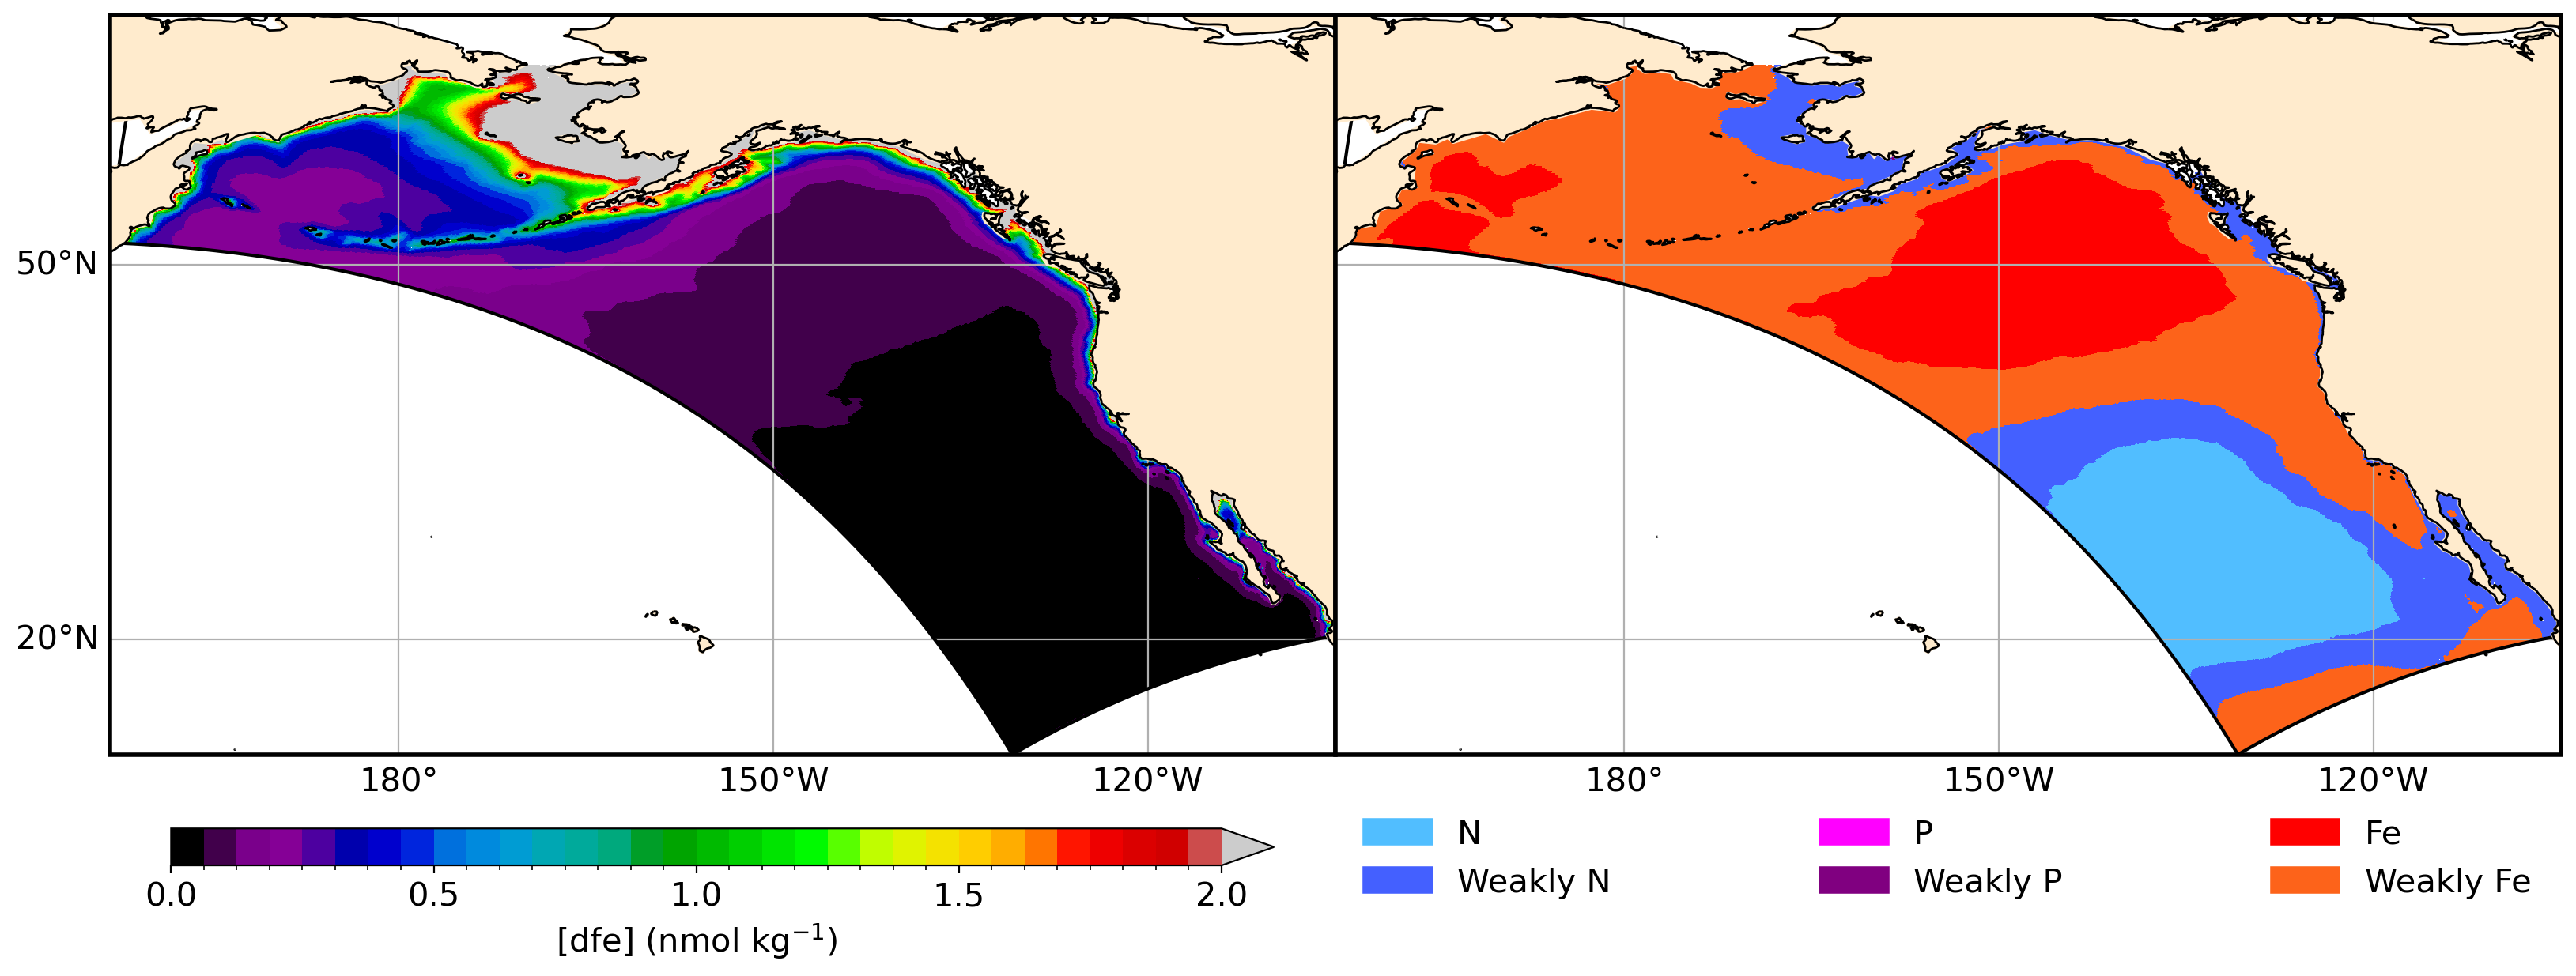

In [7]:
# NEP output
plot_fe_cbar= True
cf = (1000*1000*1000)/1035.0 # nmol kg-1
e1n_dir = '/work/role.medgrp/NEP/plotting/Figure_9/'
dfeos_fil = e1n_dir + 'nep_dfeos_1993-2019_mean_ts.nc'
dfe_fid = nc.Dataset(dfeos_fil)
nep_nut_lim_clim_fil = e1n_dir + 'nep_1993-2019_nutrient_limitations_clim.nc'
fid_mod = nc.Dataset(nep_nut_lim_clim_fil)

fig = plt.figure(figsize=(20,10),dpi=200)
spec = fig.add_gridspec(ncols=2, nrows=1,wspace=0,hspace=0.)  

dfeos = np.mean(dfe_fid.variables['dfeos'][:],axis=0)*cf # nmol kg-1
print(np.min(dfeos),np.max(dfeos))
ax1 = fig.add_subplot(spec[0,0], projection=ccrs.PlateCarree(central_longitude=-100))
plot_fe_map(ax1,dfeos)

# nut_lims = old method, nut_lims2 = new method
nut_lims,nut_lims2 = calc_lims(0,12)
ax2 = fig.add_subplot(spec[0,1], projection=ccrs.PlateCarree(central_longitude=-100))
plot_lim_map(ax2,nut_lims2)
pos = ax2.get_position()
legand_ax = fig.add_axes([pos.x0, pos.y0-.05, pos.width, .06*pos.height])
all_handles = []
for ncol in range(len(legend_titles)):
    leg_patch = mpatches.Patch(color=col_trm[ncol], label=legend_titles[ncol], linewidth = 2, edgecolor="black")
    all_handles.append(leg_patch)

legand_ax.legend(handles=all_handles, ncol = len(legend_titles)/2, mode="expand", frameon=False, prop={'size': 15})
legand_ax.axis('off')
plt.savefig('Figure9_mean_1993-2019_nep_dFe_nutrient_limitations')